# Self-Driving Car Engineer Nanodegree

## Project: Build a Traffic Sign Recognition Classifier


In this project, we will use what we've learned about deep neural networks and convolutional neural networks to classify traffic signs. Specifically, we'll train a model to classify traffic signs from the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The goals / steps of this project are the following:
* Load the data set (see below for links to the project data set)
* Explore, summarize and visualize the data set
* Design, train and test a model architecture
* Use the model to make predictions on new images
* Analyze the softmax probabilities of the new images

### Importing needed packages

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
from tensorflow.contrib.layers import flatten
from scipy.misc import imresize
from scipy.ndimage.interpolation import rotate
import matplotlib.pyplot as plt
from math import sqrt, ceil
from math import pi
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
%matplotlib inline

---
## Step 0: Load The Data

In [2]:
training_file = '../data/train.p'
validation_file= '../data/valid.p'
testing_file = '../data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Basic Summary

In [3]:
n_train = len(y_train)
n_validation = len(y_valid)
n_test = len(y_test)

image_shape = X_train.shape[1:]

df = pd.read_csv('signnames.csv')
mapping = {df.ClassId[k]: df.SignName[k] for k in range(len(df))}
n_classes = len(df)


print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using plotting traffic sign images, plotting the count of each sign, etc. 

** Plotting a sample for each class **

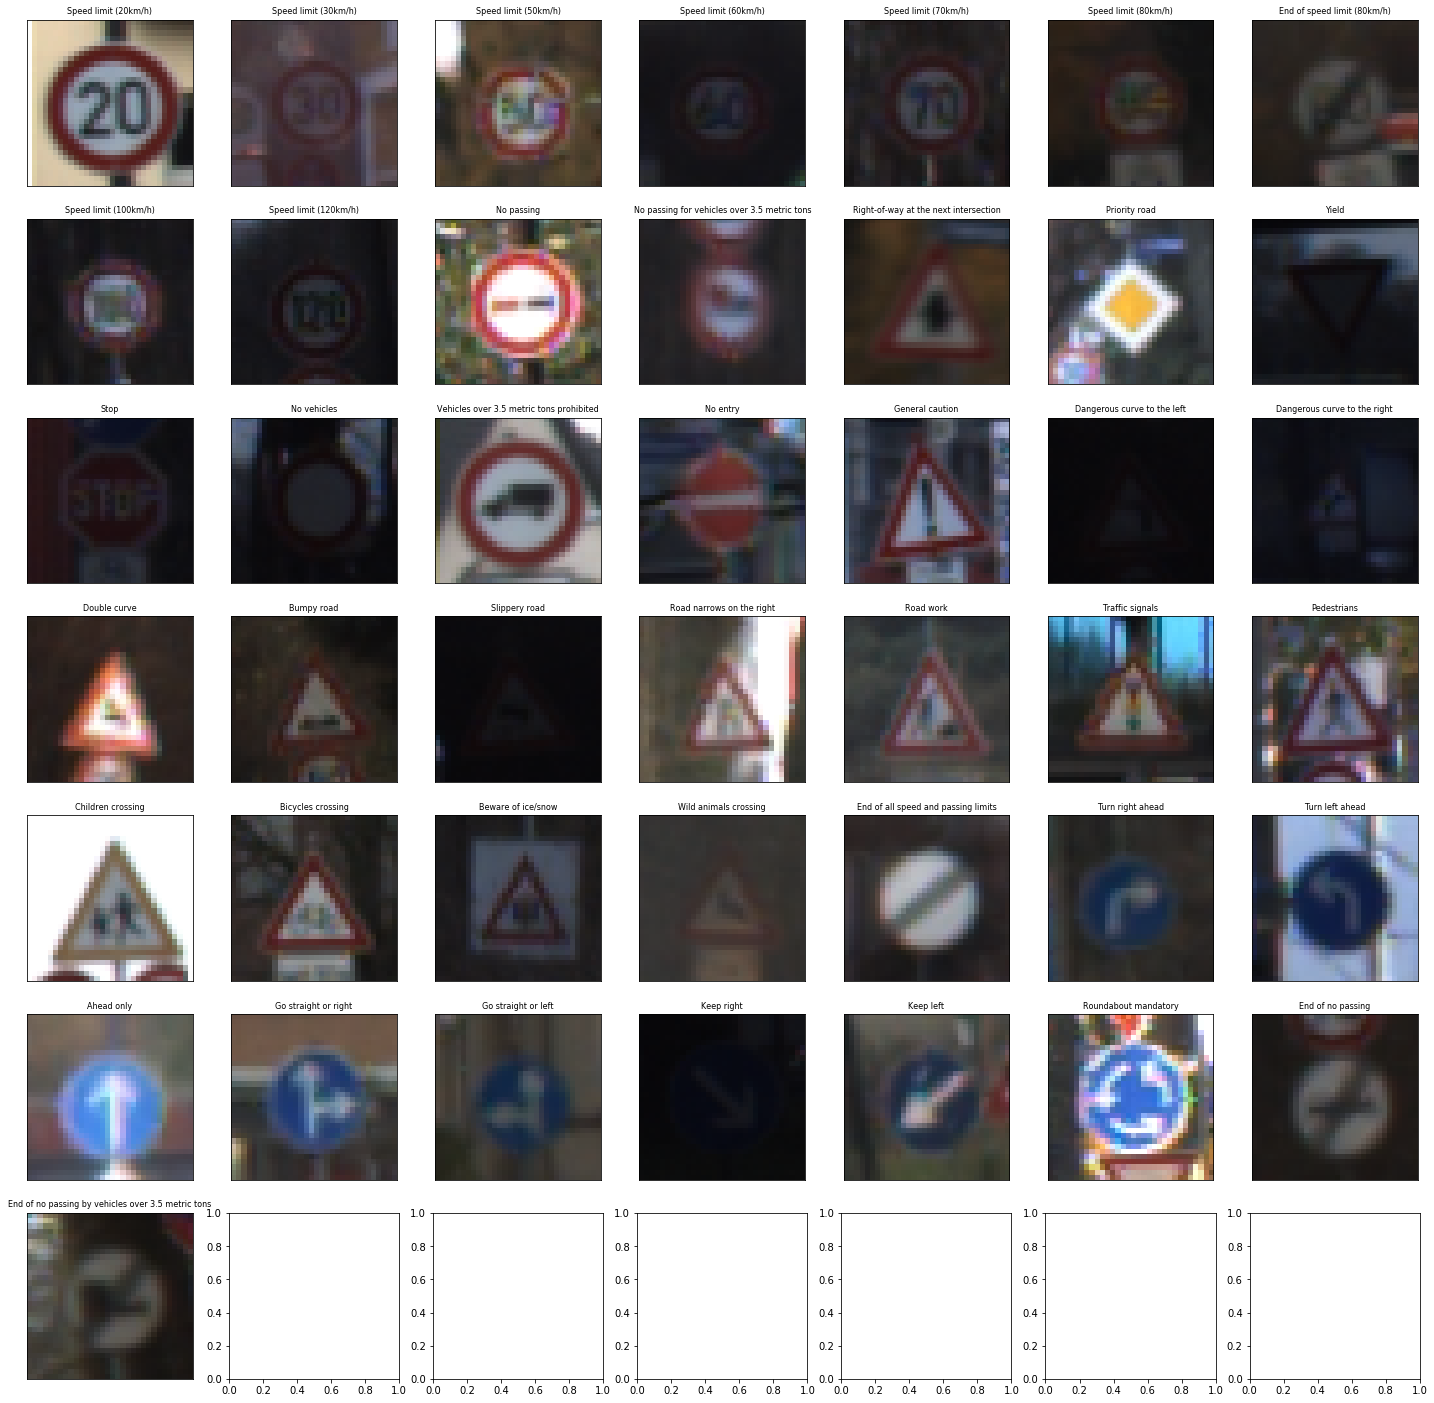

In [4]:
n_plot = ceil(sqrt(n_classes))
fig, ax = plt.subplots(nrows=n_plot,ncols=n_plot, figsize=(25,25))
ax = ax.flatten()
for k in range(n_classes):
    samples = np.where(y_train==k)
    ax[k].imshow(X_train[samples[0][0]])
    ax[k].set_title(mapping[k], fontsize=8)
    ax[k].tick_params(axis='x', colors=(0,0,0,0))
    ax[k].tick_params(axis='y', colors=(0,0,0,0))
fig.savefig('class_diversity.jpg')

** Plotting several samples for a single class **

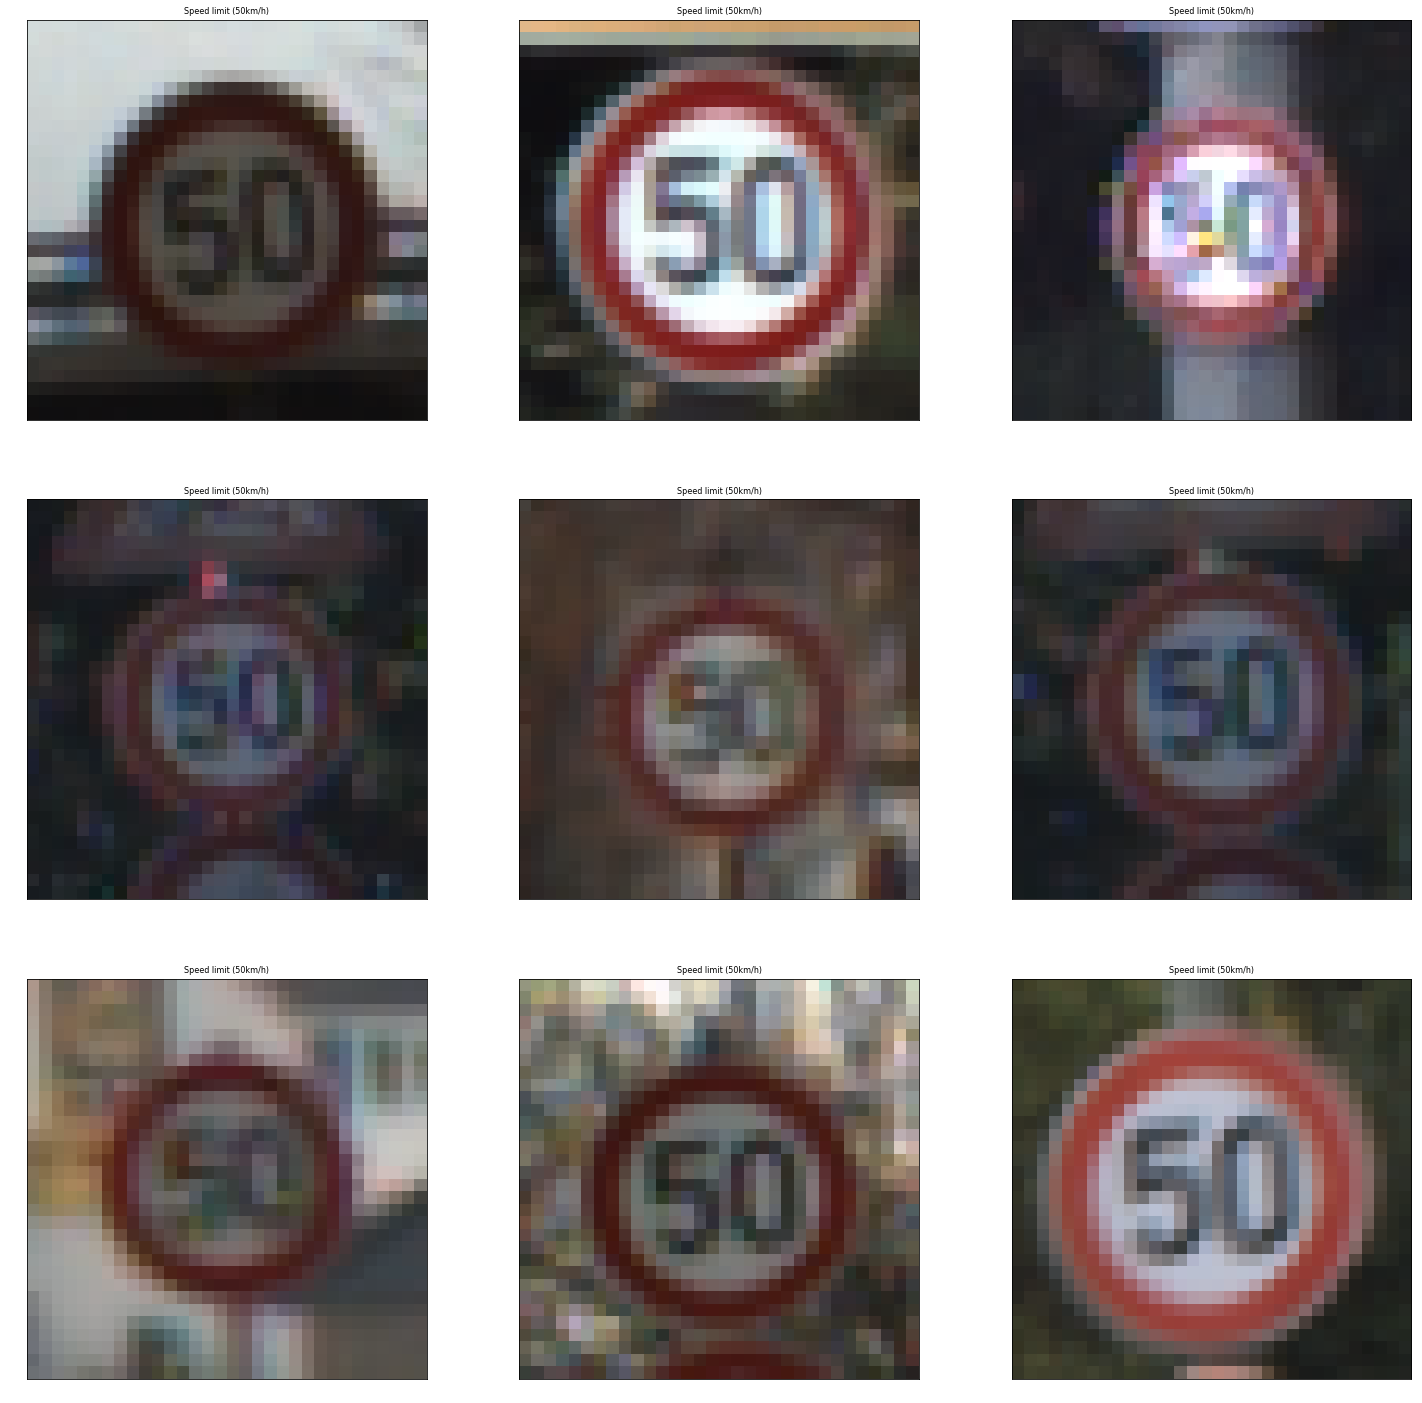

In [5]:
n_samples = 9
n_plot = ceil(sqrt(n_samples))
class_to_plot = 2
fig, ax = plt.subplots(nrows=n_plot,ncols=n_plot, figsize=(25,25))
ax = ax.flatten()
samples = shuffle(np.where(y_train==class_to_plot)[0])
for k in range(n_samples):
    ax[k].imshow(X_train[samples[k]])
    ax[k].set_title(mapping[class_to_plot], fontsize=8)
    ax[k].tick_params(axis='x', colors=(0,0,0,0))
    ax[k].tick_params(axis='y', colors=(0,0,0,0))
fig.savefig('sample_diversity.jpg')

** Plotting class distribution **

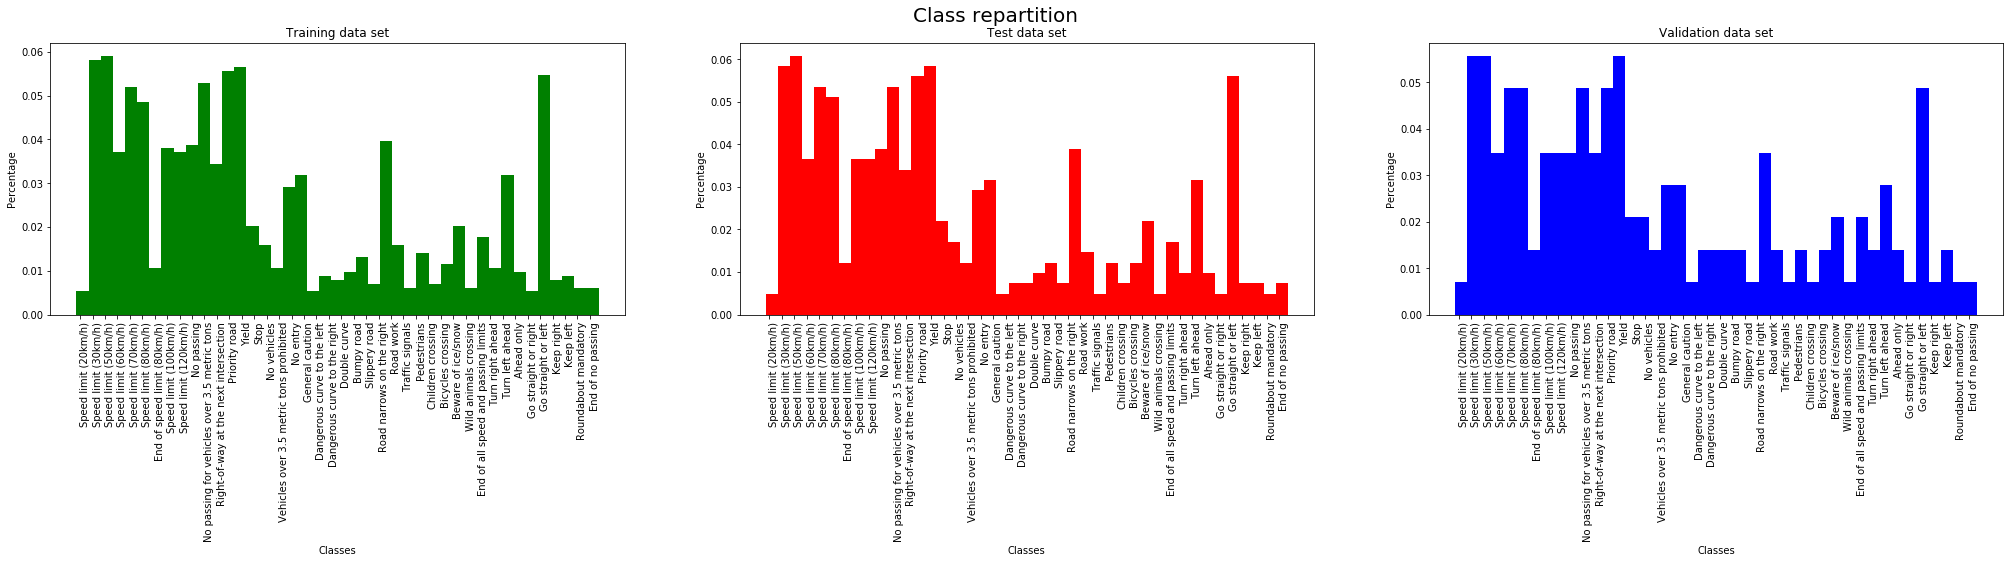

In [6]:
fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(35,5))
ax[0].hist(y_train, normed=True, color ='g',bins=43)
ax[0].set_xticks([x-0.7 for x in range(1,43)])
ax[0].set_xticklabels(mapping.values(),rotation=90, rotation_mode="anchor", ha="right")
ax[0].set_xlabel('Classes')
ax[0].set_ylabel('Percentage')
ax[0].set_title('Training data set')
ax[1].hist(y_test, normed=True, color ='r',bins=43)
ax[1].set_xticks([x-0.7 for x in range(1,43)])
ax[1].set_xticklabels(mapping.values(),rotation=90, rotation_mode="anchor", ha="right")
ax[1].set_xlabel('Classes')
ax[1].set_ylabel('Percentage')
ax[1].set_title('Test data set')
ax[2].hist(y_valid, normed=True, color ='b',bins=43)
ax[2].set_xticks([x-0.7 for x in range(1,43)])
ax[2].set_xticklabels(mapping.values(),rotation=90, rotation_mode="anchor", ha="right")
ax[2].set_xlabel('Classes')
ax[2].set_ylabel('Percentage')
ax[2].set_title('Validation data set')
fig.suptitle('Class repartition', fontsize=20)
plt.show()
fig.savefig('class_balancing.jpg')

** COMMENTS **

Based on the plots above, we can say that:
    
- Classes have the same distribution across the different datasets. In other words, we are training our model on the same kind of dataset that we will evaluate it on.
- Some classes, in particular the ones between 0 and 10, such as the speed limit signs, have more samples than others. Training our model on such unbalanced dataset could lead to better performance on certain classes that other. This can be tackled using techniques such as oversampling.
- For a given class, samples seem to show a variety of resolution, lightness but less rotation. A good way to fix this can be to use data augmentation to generate fake data. However, we can note that some techniques in data augmentation would not make sense on our particular dataset. For example, using a horizontal flip would not help and even worse could harm our classifier since it can change the class of the sample (see for example "Go straight or right" sign that would become a "Go straight or left"). We will therefore only consider mild rotation with zoom.


----

## Step 2: Design and Test a Model Architecture

The goal of this project is to design and implement a deep learning model that learns to recognize traffic signs.

As a starting point, the LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) is here implemented. With the LeNet-5 architecture, one can expect a validation set accuracy of about 0.89, with no particular data preprocessing (such data normalization or data augmentation) and no change in the architecture. However, to meet specifications, the validation set accuracy will need to be **at least 0.93**. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

'''
There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.
'''

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). 

### Baseline: LeNet-5 architecture

We use as starting point the [LeNet-5](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) architecture, introduced by LeCun & all in 1998 for document recognition. 

In [7]:
def LeNet(x, n_chanels, n_classes):    
    '''
    Returns the logits output of the LeNet-5 ConvNet
    '''
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, n_chanels, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [8]:
## Useful function to evaluate the model
def evaluate(X_data, y_data, batch_size):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

** Training hyperparameters **

In [9]:
EPOCHS = 10 # Number of epoch
BATCH_SIZE = 128 # Batch size
rate = 0.001 # Learning rate

** Building the model **

In [10]:
tf.reset_default_graph()
n_chanels = 3
# Model inputs
x = tf.placeholder(tf.float32, (None, 32, 32, n_chanels))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

# Model outputs
logits = LeNet(x, n_chanels=n_chanels, n_classes=n_classes)
# Model error function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
# Model accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# Model training operation
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

** Training the model **

In [11]:
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid, batch_size=BATCH_SIZE)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        saver.save(sess, './lenet{}'.format(i))
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.678

EPOCH 2 ...
Validation Accuracy = 0.810

EPOCH 3 ...
Validation Accuracy = 0.827

EPOCH 4 ...
Validation Accuracy = 0.846

EPOCH 5 ...
Validation Accuracy = 0.862

EPOCH 6 ...
Validation Accuracy = 0.876

EPOCH 7 ...
Validation Accuracy = 0.881

EPOCH 8 ...
Validation Accuracy = 0.896

EPOCH 9 ...
Validation Accuracy = 0.866

EPOCH 10 ...
Validation Accuracy = 0.896

Model saved


In [12]:
saver = tf.train.Saver()
with tf.Session() as sess:
    # Load the weights and bias - No Error
    saver.restore(sess, './lenet')
    train_accuracy = evaluate(X_train, y_train, batch_size=BATCH_SIZE)
    validation_accuracy = evaluate(X_valid, y_valid, batch_size=BATCH_SIZE)
    test_accuracy = evaluate(X_test, y_test, batch_size=BATCH_SIZE)

INFO:tensorflow:Restoring parameters from ./lenet


In [13]:
print('Results \n - Train accuracy: {:.3f} \n - Validation accuracy: {:.3f} \n - Test accuracy {:.3f}'.format(train_accuracy, validation_accuracy, test_accuracy))

Results 
 - Train accuracy: 0.987 
 - Validation accuracy: 0.896 
 - Test accuracy 0.873


** COMMENTS **:
- The LeNet-5 architecture, which serves as starting point in this project, yields an accuracy close to 89%
- We can notice a gap between train accuracy and validation/test accuracy suggesting overfitting

### Proposition: LeNet-5 architecture with batch normalization/dropout and data normalization/class balancing/data augmentation 

Based on the previous part, we can see that the LeNet-5 architecture seems to work fine. Therefore I won't try to complexify the model by adding layers. Instead I will try to add ingredients that will help the model to better learn.

First, regading the data, I will use:
- Oversampling to deal with unbalanced classes
- Data augmentation with mild rotation
- Scaling of the data between -1 and 1

Next, regarding the network itself, I will use :
- dropout for regularization (hopefully will reduce overfitting and help to the generalization) using [`tf.layers.dropout`](https://www.tensorflow.org/api_docs/python/tf/layers/dropout)
- Batch-normalization layers introduced [in the paper](https://arxiv.org/pdf/1502.03167.pdf). This idea is to normalize the inputs to layers within the network. I will use for that the high-level API provided by tensorflow [`tf.layers.batch_normalization `](https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization)



** Oversampling **

In [14]:
! pip install imblearn

    100% |████████████████████████████████| 153kB 2.7MB/s ta 0:00:01
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [15]:
from imblearn.over_sampling import RandomOverSampler

In [16]:
ros = RandomOverSampler()
X_balanced, y_balanced = ros.fit_sample(np.reshape(X_train,[X_train.shape[0], -1]), y_train)
X_balanced = np.reshape(X_balanced, [-1, *X_train.shape[1:]])

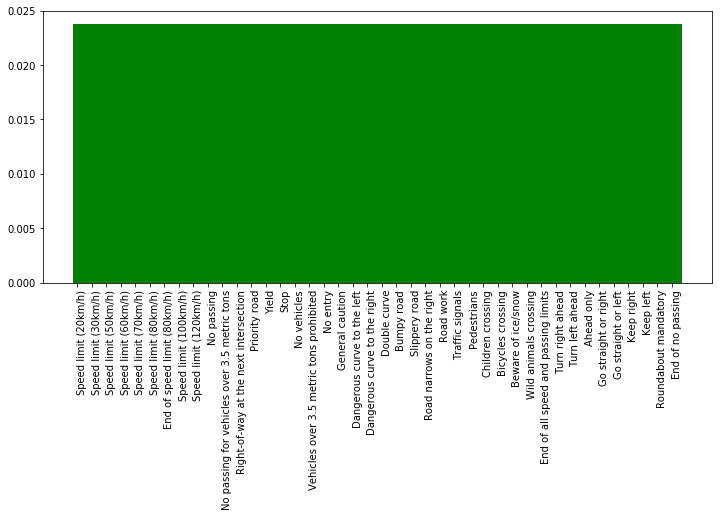

In [17]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(12,5))
ax.hist(y_balanced, normed=True, color ='g',bins=43)
ax.set_xticks([x-0.7 for x in range(1,43)])
ax.set_xticklabels(mapping.values(),rotation=90, rotation_mode="anchor", ha="right")
fig.savefig('balanced_classes.jpg')
plt.show()

** COMMENTS **:
- Now classes are balanced in the training dataset

** Data augmentation **


In [18]:
def scale_rotation(img, rot_limits = [-25, 25], scale_limits = [1.2, 1.5]):
    '''
    Performs a zoom with a random factor, then rotation with a random angle and then resize to the original size
    '''
    factor = np.random.uniform(low=scale_limits[0], high = scale_limits[1]) # random factor
    angle = np.random.uniform(low=rot_limits[0], high = rot_limits[1]) # random angle 
    img_shape = img.shape # original size
    img = imresize(img, [ceil(s*factor) for s in img_shape[:2]]) # zoom 
    img = rotate(img, angle) # rotation 
    img_scale = img.shape # new size
    img = img[-img_shape[0]//2+img_scale[0]//2:+img_shape[0]//2+img_scale[0]//2,
              -img_shape[1]//2+img_scale[1]//2:+img_shape[1]//2+img_scale[1]//2,:] # back to original size with croping at the center
    return img

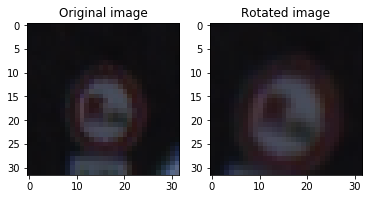

In [19]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(X_train[1])
ax[0].set_title('Original image')
ax[1].imshow(scale_rotation(X_train[1]))
ax[1].set_title('Rotated image')
fig.savefig('data_augmentation.jpg')

In [20]:
def data_augmentation(X, y, ratio = 0.2):
    '''
    Returns an augmented dataset X, y where the fake data represents fraction equal to provided ratio. To generate
    fake data we use zoom/rotation/crop
    '''
    
    n_data = ceil(n_train*ratio/(1-ratio)) # total number of fake data
    ids = np.random.choice(range(n_train), n_data) # real data ids that are going to be faked
    
    # fake data generation
    X_aug, y_aug = [], [] 
    for _ in tqdm(ids, unit='image'):
        x = scale_rotation(X[_])

        X_aug.append(x)
        y_aug.append(y[_])
         
    # concatenation
    X = np.concatenate([X_aug, X])
    y  = np.array([*y_aug, *y])
    
    # final shuffle
    X, y = shuffle(X, y) 
    
    return X, y
        

In [16]:
# Data augmentation (fake data will represent 30% of the data)
X_aug, y_aug = data_augmentation(X_balanced, y_balanced, ratio = 0.3)

100%|██████████| 14914/14914 [00:22<00:00, 656.54image/s]


** Pre-process the Data Set (normalization, grayscale, etc.) **

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and is used in this project. It is directly implemented in the network as the first step, see below.

** Model Architecture with batch-normalization and dropout **

In [21]:
def new_model(x, n_chanels, n_classes):    
    '''
    This function builds over the LeNet-5 neural network architecture and add the following ingredients:
    - Scaling of the date between -1 and 1
    - Dropout
    - Batch normalization
    '''
    
    # Scaling
    x = (x-128)/128
    
  
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1 = tf.layers.conv2d(x, filters = 6, kernel_size = [5, 5], 
                                    padding = 'VALID', use_bias=True, activation=None)
   
    conv1 = tf.layers.batch_normalization(conv1, training=is_training)
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.layers.dropout(conv1, rate=dropout, training=is_training)
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
 

    # Layer 2: Convolutional. Output = 10x10x16
    conv2 = tf.layers.conv2d(conv1, filters = 16, kernel_size = [5, 5], 
                             padding = 'VALID', use_bias=True, activation=None)
    conv2 = tf.layers.batch_normalization(conv2, training=is_training)
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.layers.dropout(conv2, rate=dropout, training=is_training)
    # Pooling. Input = 10x10x16. Output = 5x5x16
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Flatten. Input = 5x5x16. Output = 400
    fc0   = flatten(conv2)
    
    
    # Layer 3: Fully Connected. Input = 400. Output = 120
    fc1 = tf.layers.dense(fc0, 120, use_bias=True, activation=None)
    fc1 = tf.layers.batch_normalization(fc1, training=is_training)
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)
    # Layer 4: Fully Connected. Input = 120, 240 Output = 84.
    fc2 = tf.layers.dense(fc1, 84, use_bias=True, activation=None)
    fc2 = tf.layers.batch_normalization(fc2, training=is_training)
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.layers.dropout(fc2, rate=dropout, training=is_training)
    # Layer 5: Fully Connected. Input = 84. Output = n_classes.
    logits = tf.layers.dense(fc2, n_classes, use_bias=True, activation=None)
    
    return logits

In [26]:
# Useful function to evaluate the model (deals with batch normalization)
def evaluate_BN(X_data, y_data, batch_size):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, is_training : False})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

** Training hyperparameters **

In [59]:
EPOCHS = 10
BATCH_SIZE = 128
dropout = 0.3
rate = 0.05 # Learning rate

** Building the model **

In [60]:
tf.reset_default_graph()

In [61]:
n_chanels = 3
# Model inputs
x = tf.placeholder(tf.float32, (None, 32, 32, n_chanels))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
is_training = tf.placeholder(tf.bool)
# Model outputs
logits = new_model(x, n_chanels=n_chanels, n_classes=n_classes)
# Model error function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)  
# Model accuracy
prediction = tf.argmax(logits, 1)
probability = tf.nn.softmax(logits)
correct_prediction = tf.equal(prediction, tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# Model training operation (adjustement needed for batch normalization to work)
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    training_operation = tf.train.AdagradOptimizer(rate).minimize(loss_operation)

** Training the model **

In [62]:
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_balanced)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_in, y_in = shuffle(X_balanced, y_balanced)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_in[offset:end], y_in[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, is_training:True})
            
        validation_accuracy = evaluate_BN(X_valid, y_valid, batch_size=BATCH_SIZE)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        saver.save(sess, './new{}'.format(i))
        
    saver.save(sess, './new')
    print("Model saved")


Training...

EPOCH 1 ...
Validation Accuracy = 0.825

EPOCH 2 ...
Validation Accuracy = 0.884

EPOCH 3 ...
Validation Accuracy = 0.922

EPOCH 4 ...
Validation Accuracy = 0.851

EPOCH 5 ...
Validation Accuracy = 0.921

EPOCH 6 ...
Validation Accuracy = 0.939

EPOCH 7 ...
Validation Accuracy = 0.918

EPOCH 8 ...
Validation Accuracy = 0.947

EPOCH 9 ...
Validation Accuracy = 0.949

EPOCH 10 ...
Validation Accuracy = 0.940

Model saved


In [64]:
saver = tf.train.Saver()
with tf.Session() as sess:
    # Load the weights and bias - No Error
    saver.restore(sess, './new')
    train_accuracy = evaluate_BN(X_train, y_train, batch_size=BATCH_SIZE)
    validation_accuracy = evaluate_BN(X_valid, y_valid, batch_size=BATCH_SIZE)
    test_accuracy = evaluate_BN(X_test, y_test, batch_size=BATCH_SIZE)

INFO:tensorflow:Restoring parameters from ./new


In [65]:
print('Results \n - Train accuracy: {:.3f} \n - Validation accuracy: {:.3f} \n - Test accuracy {:.3f}'.format(train_accuracy, validation_accuracy, test_accuracy))

Results 
 - Train accuracy: 0.986 
 - Validation accuracy: 0.940 
 - Test accuracy 0.937


In [66]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes, rotation=90, fontsize = 18)
    plt.yticks(tick_marks, classes, fontsize = 18)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [117]:
# Useful function to make prediction by batch (deals with batch normalization)
def prediction_BN(X_data, y_data, batch_size):
    num_examples = len(X_data)
    y_pred = []
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        pred = sess.run(prediction, feed_dict={x: batch_x, y: batch_y, is_training : False})
        y_pred.extend(list(pred))
    return y_pred

In [118]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, './new')
    y_pred = prediction_BN(X_test, y_test, batch_size=BATCH_SIZE)

INFO:tensorflow:Restoring parameters from ./new


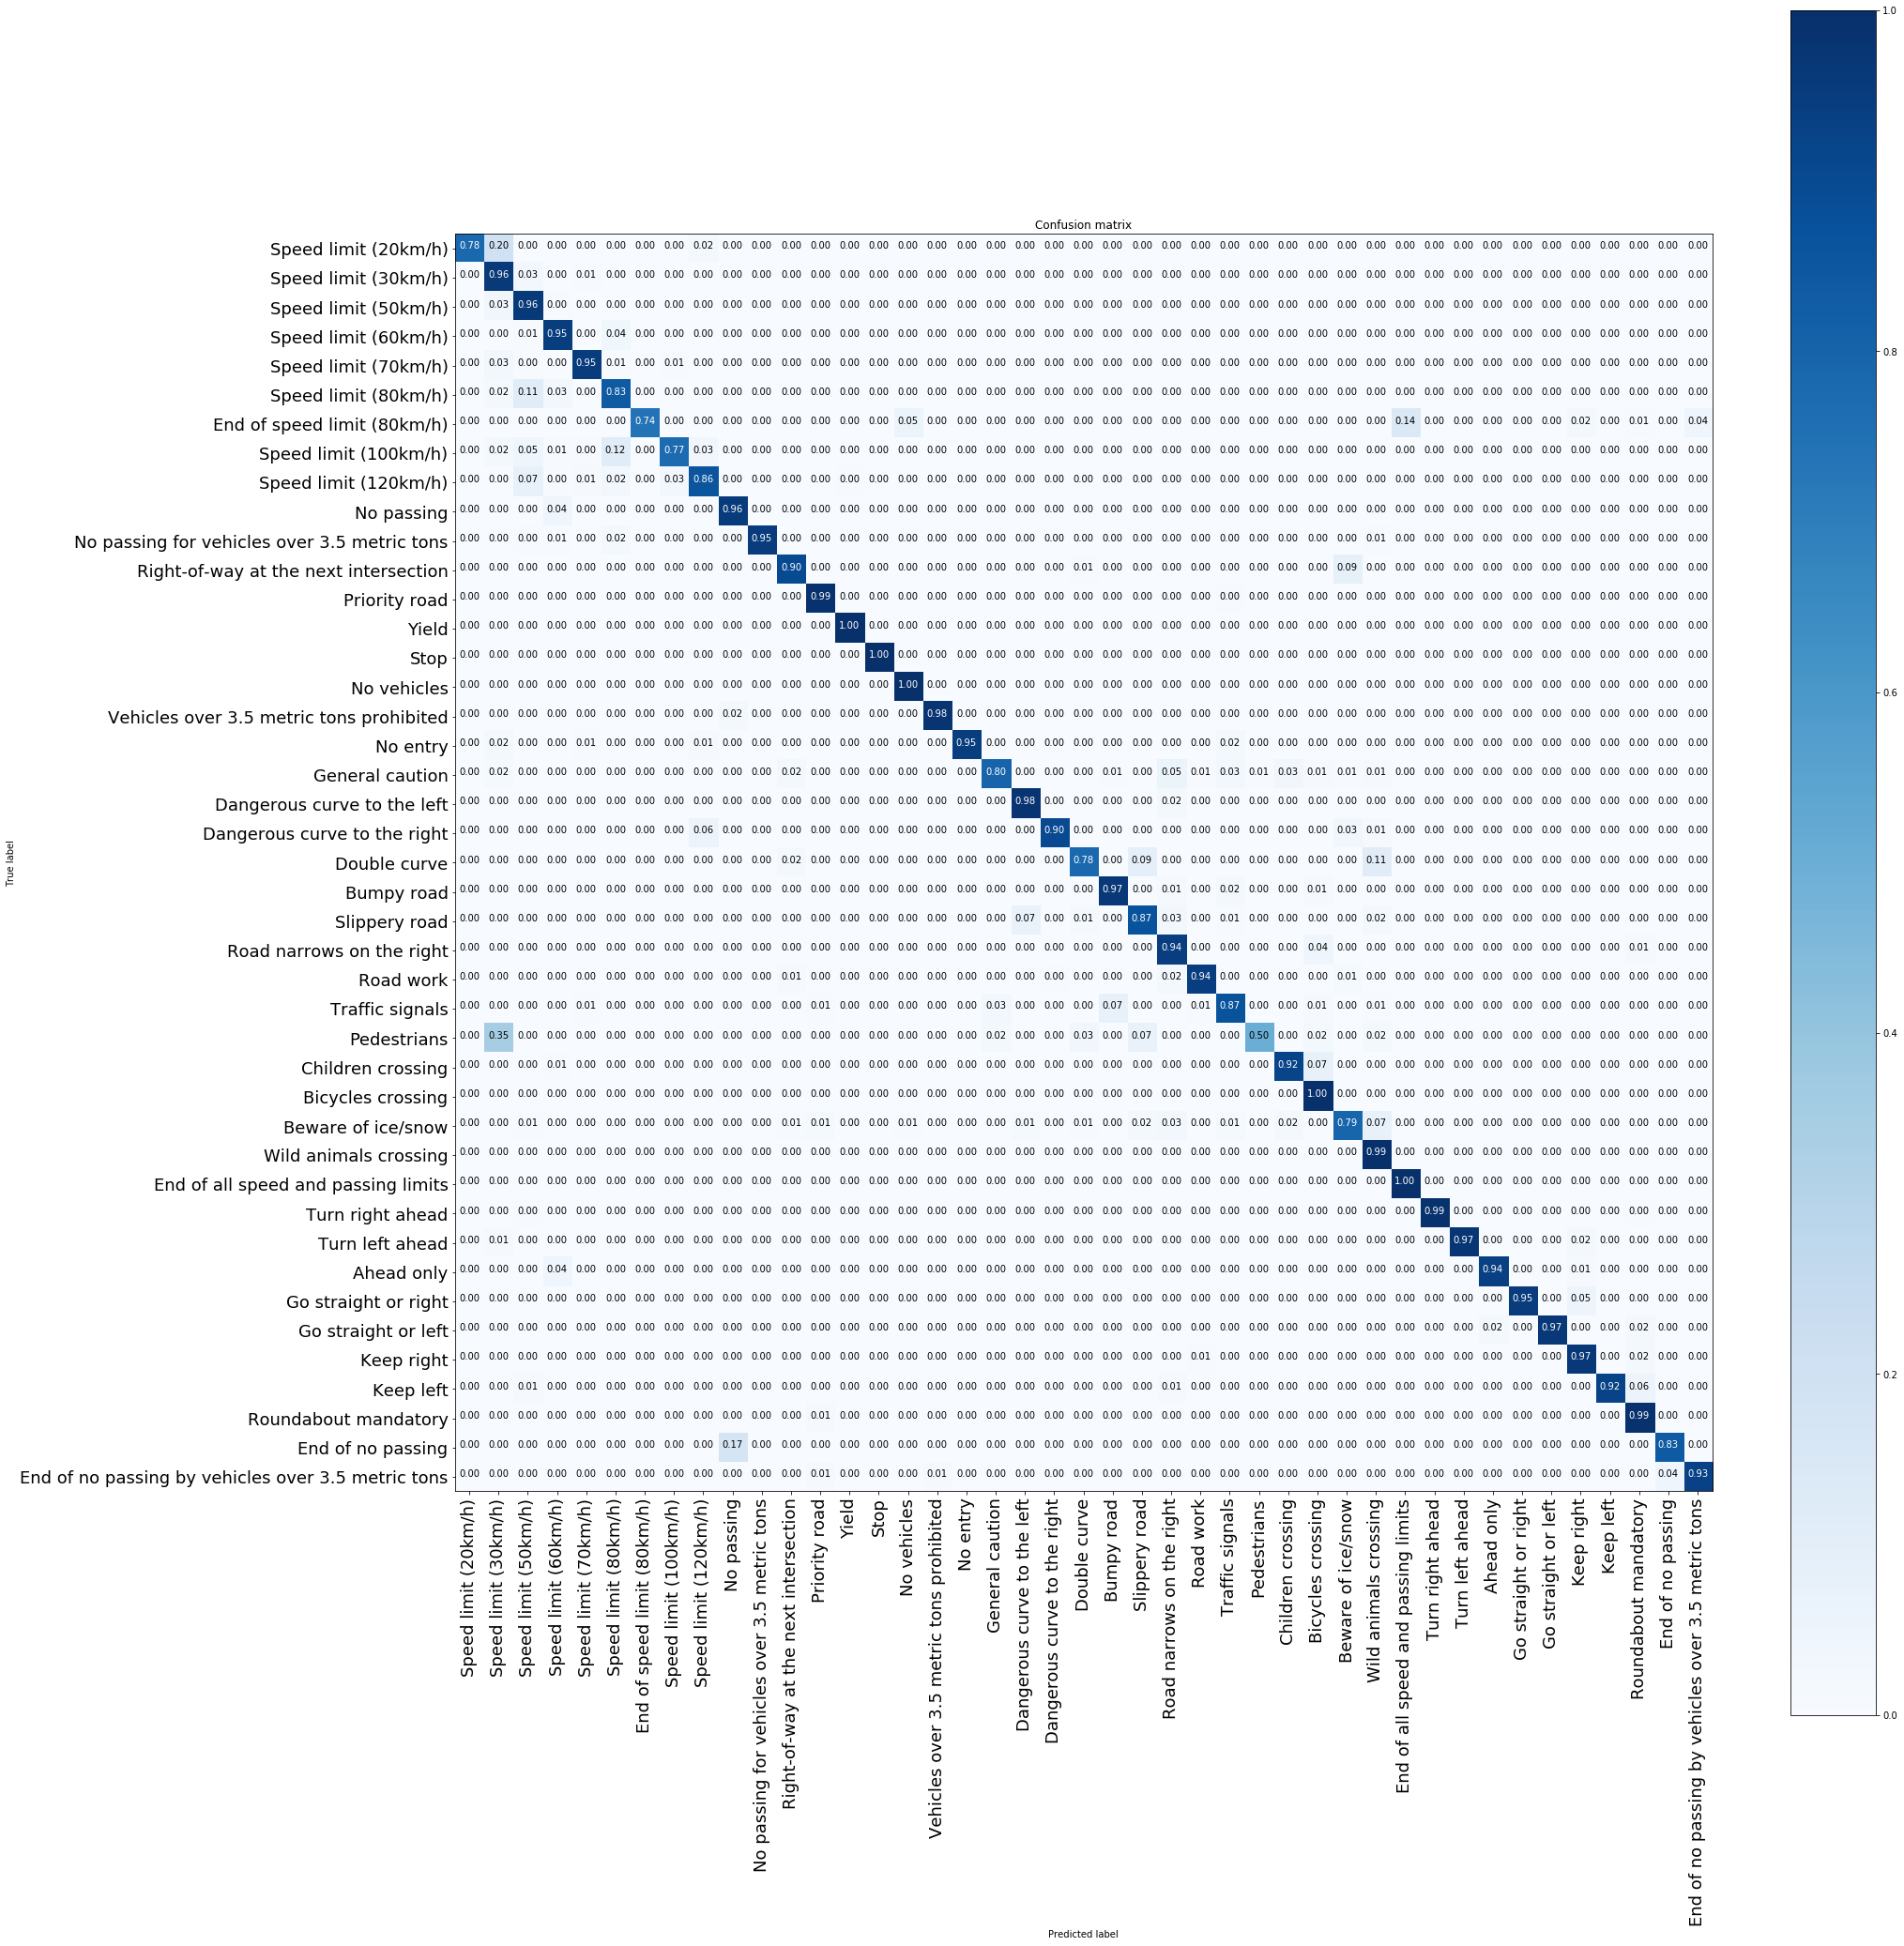

In [119]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
classes = [mapping[k] for k in mapping]
# Plot non-normalized confusion matrix
plt.figure(figsize=(30,30))
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix', normalize = True)

** COMMENTS **

The results above show that : 
- Thanks to the modifications implemented, we are able to reach an accuracy over 0.93 on the validation dataset
- The confusion matrix reveals that some confusions exist between the classes, for example between the speed limit signs


---

## Step 3: Test a Model on New Images

To have more insight into how the model is working, we will use five pictures of German traffic signs from the web and use the model to predict the traffic sign type.


### Load the images and resize them

In [67]:
import PIL
from PIL import Image

In [68]:
X_web = []
for k in range(1,6):
    img = Image.open('sign{}.jpg'.format(k))
    img = img.resize((32, 32), PIL.Image.ANTIALIAS)
    X_web.append(np.array(img))

### Predict the Sign Type for Each Image

In [122]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, './new')
    test_predictions = sess.run(prediction, feed_dict={x: X_web, y: np.ones(shape=(5,)), is_training:False})

INFO:tensorflow:Restoring parameters from ./new


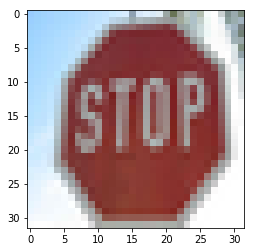

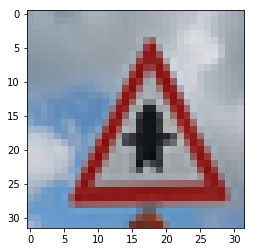

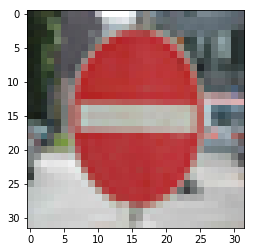

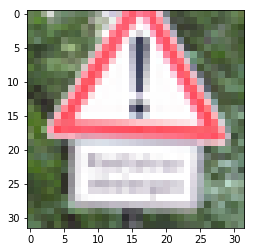

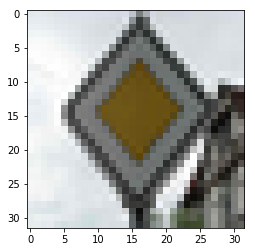

In [69]:
for k in range(5):
    plt.imshow(X_web[k])
    plt.title('Prediction: '+mapping[test_predictions[k]])
    plt.show()
    

### Analyze Performance

** COMMENTS ** 

80% of accuracy on this small dataset of 5 images. The general caution sign is misinterpreted as a no passing sign.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

Moreover, for each of the new images, we print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). We use for that [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k). 



In [124]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, './new')
    probs = sess.run(probability, feed_dict={x: X_web, y: np.ones(shape=(5,)), is_training:False})
    topk = sess.run(tf.nn.top_k(tf.constant(probs), k=5))

INFO:tensorflow:Restoring parameters from ./new


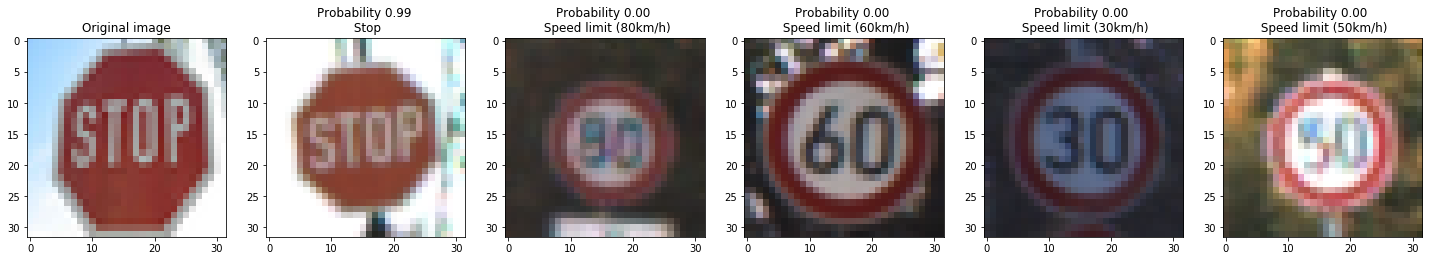

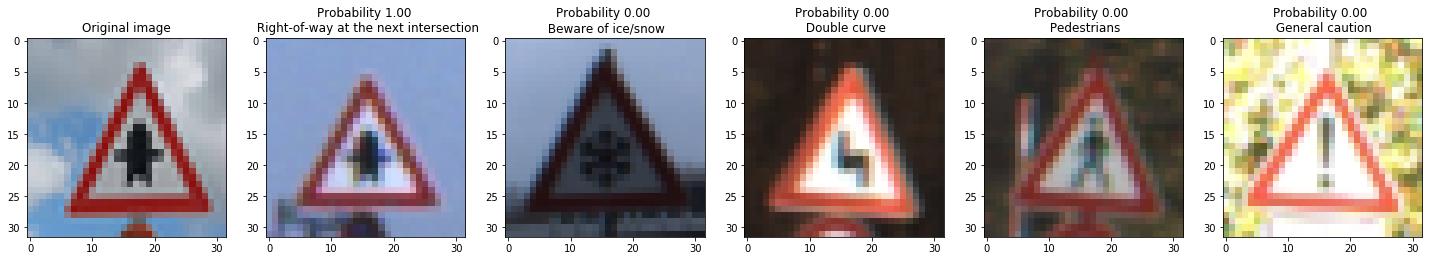

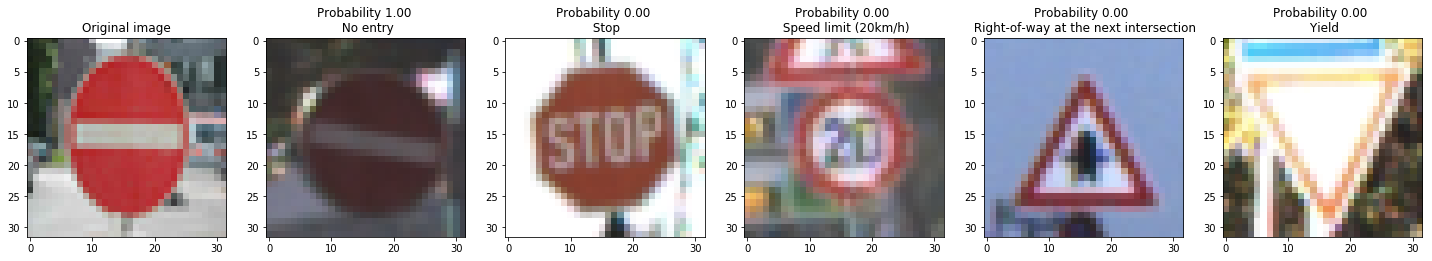

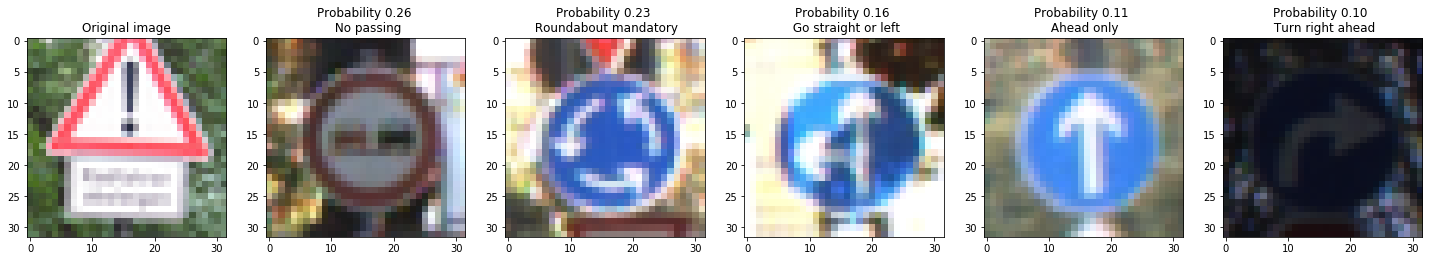

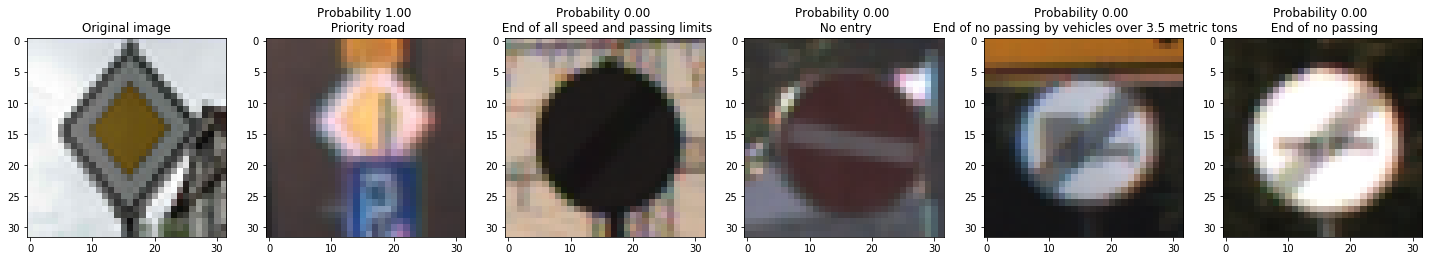

In [129]:
for k in range(5):
    f, ax = plt.subplots(ncols=6, figsize=(25,5))
    ax = ax.ravel()
    ax[0].imshow(X_web[k])
    ax[0].set_title('Original image')
    for i in range(5):
        i_th_prediction = topk[1][k][i]
        i_th_probability = topk[0][k][i]
        example = X_train[np.where(y_train==i_th_prediction)[0][0]]
        ax[1+i].imshow(example)
        ax[1+i].set_title('Probability {:.2f} \n {}'.format(i_th_probability, mapping[i_th_prediction]))
    plt.show()
    f.savefig('sign{}_prediction.jpg'.format(k))

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")